In [ ]:
#!pip install torch==1.5.0+cpu torchvision==0.6.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

import findspark
findspark.init()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import array, rand, col

In [5]:
import pandas as pd
import numpy as np
import pickle
import collections
from tqdm.notebook import tqdm
from IPython.display import clear_output

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

In [7]:
MEMORY_SIZE = '5g'
spark = SparkSession \
    .builder \
    .config('spark.driver.memory', MEMORY_SIZE) \
    .appName('spark-taxi') \
    .getOrCreate()

In [9]:
path_to_data = '/content/drive/My Drive/green_taxi_prepare/'

In [10]:
data = spark.read.parquet(path_to_data)
data.show(3)
data.printSchema()

+-------------------+---------------+------+-------------------+---------------+------------------+
|           datetime|          state|action|             reward|     next_state|     duration_trip|
+-------------------+---------------+------+-------------------+---------------+------------------+
|2019-06-21 18:07:10|[243, 18, 6, 0]|   243|  7.266666666666667|[243, 18, 6, 0]|10.466666666666667|
|2019-06-06 14:29:09|[243, 14, 5, 0]|   243|-10.391666666666666|[243, 15, 5, 0]| 38.78333333333333|
|2019-06-07 21:49:43|[243, 21, 6, 0]|   243|-3.4000000000000004|[243, 22, 6, 0]|              15.8|
+-------------------+---------------+------+-------------------+---------------+------------------+
only showing top 3 rows

root
 |-- datetime: timestamp (nullable = true)
 |-- state: struct (nullable = true)
 |    |-- location: integer (nullable = true)
 |    |-- hour: integer (nullable = true)
 |    |-- weekday: integer (nullable = true)
 |    |-- holiday: integer (nullable = true)
 |-- action:

In [11]:
train_data = data
test_data = data

In [12]:
train_data = train_data.select(array('state.*').alias('state'),
                   'action',
                   'reward',
                   array('next_state.*').alias('next_state'),
                   'duration_trip').cache()

In [13]:
test_data = test_data.select(array('state.*').alias('state'),
                   'action',
                   'reward',
                   array('next_state.*').alias('next_state'),
                   'duration_trip').cache()

In [14]:
print(train_data.count())
print(test_data.count())

440934
440934


In [15]:
class SparkDataset():

    def __init__(self, df):
        self.df = df

    def sample_generator(self):
        gen = self.df.orderBy(rand()).toLocalIterator()
        for sample in gen:
            yield {'state': tuple(sample['state']), 'action': sample['action'], 'reward': sample['reward'], 
                   'next_state': tuple(sample['next_state']), 'duration_trip': sample['duration_trip']}

    def __iter__(self):
        return self.sample_generator()

In [16]:
class TaxiEnv:
    
    def __init__(self, dataset):
        self.env = collections.defaultdict(lambda: collections.defaultdict(list))
        i = 0
        for sample in dataset:
            
            s = sample['state']
            a = sample['action']
            r = sample['reward']
            next_s = sample['next_state']
            d = sample['duration_trip']
            
            self.env[s][a].append((next_s, r, d))
            i += 1
        print(i)
            
        self.state_count = len(self.env.keys())
        
    def step(self, state, action):
        if self.env[state][action]:
            x = list(map(list, zip(*self.env[state][action])))
            i = np.random.choice(len(x[2]))
            next_state = x[0][i]
            reward = x[1][i]
            duration = x[2][i]
        else:
            reward = 0.
            duration = 0.
            next_state = self.get_random_state()
        return next_state, reward, duration
    
    def get_random_state(self):
        i = np.random.choice(self.state_count)
        key = list(self.env.keys())[i]
        return key

In [17]:
def generate_session(agent, env, t_max=8*60):
    reward = 0
    duration = 0
    state = env.get_random_state()
    i = 0
    while duration < t_max and i < 200:
        action = agent.get_best_action(state)
        next_s, r, d = env.step(state, action)
        reward += r
        duration += d
        state = next_s
        i += 1
      
    return reward

In [18]:
class SimpleAgent:
    
    def __init__(self, best_actions=[7]):
        self.best_actions = best_actions

    def get_best_action(self, state):
        action = np.random.choice(self.best_actions)
        return int(action)

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset

In [20]:
class NeuralAgent:
    
  def __init__(self, network, opt, transform=None):
    self.network = network
    self.opt = opt
    self.transform = transform

  def train(self, sample):
    self.network.train()

    states = [sample['state']]
    actions = [sample['action'] - 1]
    rewards = [sample['reward']]
    next_states = [sample['next_state']]

    if self.transform:
      states = self.transform.transform(states)
      next_states = self.transform.transform(next_states)

    self.opt.zero_grad()
    compute_td_loss(states, actions, rewards, next_states).backward()
    self.opt.step()

  def get_best_action(self, state):
    self.network.eval()

    states = [state]
    if self.transform:
      states = self.transform.transform(states)
    states = torch.tensor(states, dtype=torch.float32).to(device)
    q_values = self.network(states).detach().to('cpu').numpy()
    action = np.argmax(q_values)
    return int(action) + 1

In [21]:
def to_one_hot(y_tensor, n_dims=None):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(
        y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1).to(device)
    return y_one_hot


def where(cond, x_1, x_2):
    """ helper: like np.where but in pytorch. """
    return (cond * x_1) + ((1-cond) * x_2)

In [22]:
def compute_td_loss(states, actions, rewards, next_states, gamma=0.99, check_shapes=False):
    """ Compute td loss using torch operations only. Use the formula above. """
    states = torch.tensor(
        states, dtype=torch.float32).to(device)    # shape: [batch_size, state_size]
    actions = torch.tensor(actions, dtype=torch.int32).to(device)   # shape: [batch_size]
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)  # shape: [batch_size]
    # shape: [batch_size, state_size]
    next_states = torch.tensor(next_states, dtype=torch.float32).to(device)

    # get q-values for all actions in current states
    predicted_qvalues = network(states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = torch.sum(
        predicted_qvalues * to_one_hot(actions, n_actions), dim=1)

    # compute q-values for all actions in next states
    predicted_next_qvalues =  network(next_states)

    # compute V*(next_states) using predicted next q-values
    with torch.no_grad():
        next_state_values =  torch.max(predicted_next_qvalues, dim=1)[0]

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    target_qvalues_for_actions =  rewards + gamma * next_state_values

    # mean squared error loss to minimize
    loss = F.smooth_l1_loss(predicted_qvalues_for_actions,
                       target_qvalues_for_actions.detach())

    return loss

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device('cpu')

In [24]:
possible_actions = np.arange(1,266)
n_actions = len(possible_actions)
state_dim = 6

In [25]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [27]:
categories = [np.arange(1,266), np.arange(0,24), np.arange(1,8), np.arange(0,2)]
encoder = OneHotEncoder(categories=categories, drop='first', sparse=False).fit([[3, 0, 5, 0]])
state_dim = len(encoder.get_feature_names())

In [ ]:
hidden_neurons = 128

network = nn.Sequential()

network.add_module('layer1', nn.Linear(state_dim, hidden_neurons))
network.add_module('relu1', nn.LeakyReLU())
network.add_module('dropout1', nn.Dropout())
network.add_module('layer2', nn.Linear(hidden_neurons, 64))
network.add_module('relu2', nn.LeakyReLU())
network.add_module('dropout2', nn.Dropout())
network.add_module('layer3', nn.Linear(64, n_actions))

network = network.to(device)

In [ ]:
hidden_neurons = 32

network = nn.Sequential()

network.add_module('layer1', nn.Linear(state_dim, hidden_neurons))
network.add_module('relu1', nn.LeakyReLU())
network.add_module('dropout1', nn.Dropout())
network.add_module('layer3', nn.Linear(hidden_neurons, n_actions))

network = network.to(device)

In [28]:
network = nn.Sequential()
network.add_module('layer1', nn.Linear(state_dim, n_actions))
network = network.to(device)

In [34]:
opt = torch.optim.Adam(network.parameters(), lr=1e-5)

In [35]:
agent = NeuralAgent(network, opt, encoder)

In [31]:
train_dataset = SparkDataset(train_data)
test_dataset = SparkDataset(test_data)

In [32]:
test_env = TaxiEnv(test_dataset)

440934


In [33]:
simple_agent = SimpleAgent([95])
np.mean([generate_session(simple_agent, test_env) for _ in range(1000)])

237.63849166666668

In [36]:
history_rewards = []

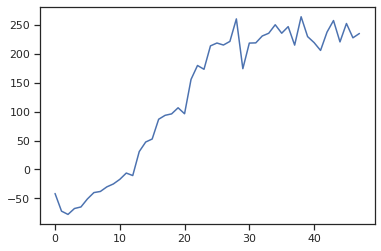

[27, 84, 95, 95, 5, 95, 5, 8, 23, 59, 95, 221, 118, 30, 103, 5, 23, 30, 23, 23, 95, 46, 206, 118, 5, 30, 30, 103, 221, 84, 5, 15, 221, 95, 99, 5, 95, 187, 245, 245, 183, 245, 118, 118, 156, 5, 103, 5, 23, 5]


KeyboardInterrupt: ignored

In [38]:
for i_batch, sample in enumerate(train_dataset):
  agent.train(sample)
  if not i_batch % 10000:
    with torch.no_grad():
      history_rewards.append(np.mean([generate_session(agent, test_env) for _ in range(50)]))
      clear_output(True)
      plt.plot(history_rewards)
      plt.show()
      print([agent.get_best_action(test_env.get_random_state()) for _ in range(50)])

In [39]:
%%time
iters = 1000

validation_simple = [{'type': 'simple_agent', 'reward': generate_session(simple_agent, test_env)} for _ in range(iters)]
validation_agent = [{'type': 'agent', 'reward': generate_session(agent, test_env)} for _ in range(iters)]

val_df = pd.DataFrame(validation_simple + validation_agent)

CPU times: user 2min 15s, sys: 799 ms, total: 2min 16s
Wall time: 2min 16s


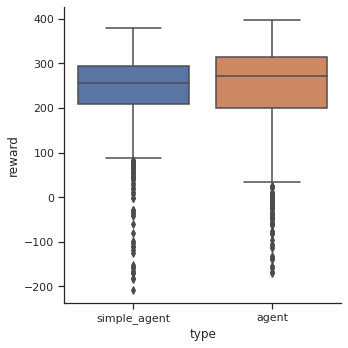

In [41]:
sns.catplot(x="type", y="reward",kind='box', data=val_df);

272.29166666666663


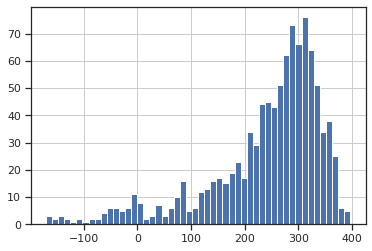

In [42]:
print(val_df.loc[val_df['type'] == 'agent', 'reward'].median())
val_df.loc[val_df['type'] == 'agent', 'reward'].hist(bins=50);

256.40833333333336


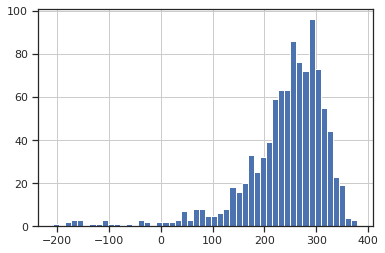

In [43]:
print(val_df.loc[val_df['type'] == 'simple_agent', 'reward'].median())
val_df.loc[val_df['type'] == 'simple_agent', 'reward'].hist(bins=50);

In [45]:
torch.save(network, '/content/drive/My Drive/torch-network')

In [46]:
pickle.dump(encoder, open('/content/drive/My Drive/sklearn-transformer', 'wb'))